# Online Spherical Entropy Calculations -- Demo Notebook

## 0. Setup

### 0.1. Imports

In [1]:
## Set the PYTHON package path
import os, sys
package_root = os.path.abspath('../src/')
if package_root not in sys.path:
    sys.path.insert(0, package_root)

#package_root

In [2]:
## Import soft entropy calculation routines
from nam_entropy import *


# Import SciPy distributions
from scipy import stats

## Import the Pytorch distributions
import torch

### 0.2. Fix Randomness

In [3]:
RANDOM_SEED = 42
set_all_random_seeds(RANDOM_SEED)

All random seeds set to 42 (deterministic mode)


## 1. Create Sample Data

In [4]:
## Define some example SciPy distributions in 2D
dist1 = stats.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]]) # Standard normal
dist2 = stats.multivariate_normal(mean=[1.5, 3], cov=[[1, 0.5], [0.5, 1]]) # Different normal with correlations

## Define some example PyTorch distributions in 2D
from torch.distributions import Uniform
dist3 = Uniform(
    low=torch.tensor([-2.0, -1.0]),
    high=torch.tensor([2.0, 0.0])
)



In [5]:
## Get some associated sample data from these distributions
n_samples_list = [10, 20, 30]
distribution_list = [dist1, dist2, dist3]
label_list = ['A - Std Normal', 'B - Correlated Normal', 'C - Uniform on [-2, 2] x [-1, 0]']

randomized_data_df = \
    make_samples_dataframe_from_distributions(n_samples_list, distribution_list, label_list, 
                                              label_columns_name = 'label', 
                                              data_component_name_list=None, 
                                              randomize_samples = True)


## 2. Pytorch Preparation of Sample Data

In [6]:
## Convert the data to PyTorch format
index_tensor, data_tensor, label_list, label_list_row_index_lookup_dict = \
    data_df_to_pytorch_data_tensors_and_labels(randomized_data_df)


## 3. Perform Online Entropy Estimation

### 3.0. Set Soft-Binning Parameters

In [7]:
## Setup the binning parameters
n_bins = 10
n_heads = 1  ## NOTE: This needs to be reset from its default value of 4...  probably change this default value to 1!
bin_type = "unit_sphere"
dist_fn = "cosine"
smoothing_fn = "softmax"
smoothing_temp = 1.0

### 3.1. Basic Online Usage - Process Data in Batches

Here we split our dataset into batches and process them incrementally,
demonstrating that online computation gives the same results as batch computation.


In [8]:
# Import the EntropyAccumulator
from nam_entropy import EntropyAccumulator

# Initialize the accumulator with the same parameters we used before
# IMPORTANT: We now pass embedding_dim to enable bin pre-computation for data-independent bin types
acc = EntropyAccumulator(
    n_bins=n_bins,
    label_list=label_list,
    embedding_dim=data_tensor.shape[1],  # Pass embedding dimension for bin pre-computation
    n_heads=n_heads,
    dist_fn=dist_fn,
    bin_type=bin_type,
    smoothing_fn=smoothing_fn,
    smoothing_temp=smoothing_temp
)

# Split our data into 3 batches (we have 60 samples total)
batch_size = 20
n_samples = data_tensor.shape[0]

for i in range(0, n_samples, batch_size):
    # Get batch slice
    batch_data = data_tensor[i:i+batch_size]
    batch_indices = index_tensor[i:i+batch_size]

    # Update the accumulator with this batch
    acc.update(batch_data, batch_indices)
    print(f"Processed batch {i//batch_size + 1}: samples {i} to {min(i+batch_size, n_samples)}")

# Compute metrics from the accumulated state
online_metrics = acc.compute_metrics()

print("\n=== Online Computation Results ===")
print(f"Total Population Entropy: {online_metrics['output_metrics']['entropy']:.6f}")
print(f"Conditional Entropy (weighted): {online_metrics['output_metrics']['conditional_entropy']:.6f}")
print(f"Mutual Information (weighted): {online_metrics['output_metrics']['mutual_information']:.6f}")
print(f"\nEntropy by label:")
for label, h in online_metrics['output_metrics']['label_entropy_dict'].items():
    print(f"  {label}: {h:.6f}")


Processed batch 1: samples 0 to 20
Processed batch 2: samples 20 to 40
Processed batch 3: samples 40 to 60

=== Online Computation Results ===
Total Population Entropy: 2.299374
Conditional Entropy (weighted): 2.228843
Mutual Information (weighted): 0.070531

Entropy by label:
  total_population: 2.299374
  A - Std Normal: 2.248206
  B - Correlated Normal: 2.162937
  C - Uniform on [-2, 2] x [-1, 0]: 2.266325


### 3.2. Compare Online vs Batch Computation 

Let's verify that online computation gives identical results to batch computation.
With the embedding_dim parameter, bins are pre-computed at initialization time,
ensuring identical bins for both batch and online computation.

In [9]:
# Use the original batch function for comparison
# IMPORTANT: Pass the pre-computed bins from the accumulator to ensure identical bins
from nam_entropy import compute_all_entropy_measures

# Convert bins to match data tensor's dtype and device
bins_for_batch = acc.bins.to(dtype=data_tensor.dtype, device=data_tensor.device)

batch_metrics = compute_all_entropy_measures(
    data_embeddings_tensor=data_tensor,
    data_label_indices_tensor=index_tensor,
    label_list=label_list,
    n_bins=n_bins,
    n_heads=n_heads,
    dist_fn=dist_fn,
    bin_type=bin_type,
    smoothing_fn=smoothing_fn,
    smoothing_temp=smoothing_temp,
    conditional_entropy_label_weighting="weighted",
    online_bins=bins_for_batch  # Use the same bins as the online accumulator
)

print("\n=== Batch vs Online Comparison ===")
print(f"Total Population Entropy - Batch:  {batch_metrics['output_metrics']['entropy']:.6f}")
print(f"Total Population Entropy - Online: {online_metrics['output_metrics']['entropy']:.6f}")
print(f"Difference: {abs(batch_metrics['output_metrics']['entropy'] - online_metrics['output_metrics']['entropy']):.2e}")

print(f"\nConditional Entropy - Batch:  {batch_metrics['output_metrics']['conditional_entropy']:.6f}")
print(f"Conditional Entropy - Online: {online_metrics['output_metrics']['conditional_entropy']:.6f}")
print(f"Difference: {abs(batch_metrics['output_metrics']['conditional_entropy'] - online_metrics['output_metrics']['conditional_entropy']):.2e}")

print(f"\nMutual Information - Batch:  {batch_metrics['output_metrics']['mutual_information']:.6f}")
print(f"Mutual Information - Online: {online_metrics['output_metrics']['mutual_information']:.6f}")
print(f"Difference: {abs(batch_metrics['output_metrics']['mutual_information'] - online_metrics['output_metrics']['mutual_information']):.2e}")




=== Batch vs Online Comparison ===
Total Population Entropy - Batch:  2.299374
Total Population Entropy - Online: 2.299374
Difference: 0.00e+00

Conditional Entropy - Batch:  2.228843
Conditional Entropy - Online: 2.228843
Difference: 0.00e+00

Mutual Information - Batch:  0.070531
Mutual Information - Online: 0.070531
Difference: 0.00e+00


### 3.3. Distributed Computation - Merging Multiple Accumulators

This example simulates distributed computation where different workers process
different portions of the data, then merge their results.

IMPORTANT: All workers must use the same embedding_dim to ensure they all
pre-compute identical bins (assuming the same random seed).

In [10]:
# Simulate 3 workers processing different portions of the data
worker_data_splits = [
    (data_tensor[0:20], index_tensor[0:20]),    # Worker 1: samples 0-19
    (data_tensor[20:40], index_tensor[20:40]),  # Worker 2: samples 20-39
    (data_tensor[40:60], index_tensor[40:60])   # Worker 3: samples 40-59
]

# IMPORTANT: In distributed computing, all workers must share the same bins
# We reuse the bins from our original accumulator to ensure consistency
shared_bins = acc.bins

# Each worker creates and updates its own accumulator
# NOTE: We don't pass embedding_dim because we will manually set the bins
accumulators = []
for worker_id, (worker_data, worker_indices) in enumerate(worker_data_splits):
    worker_acc = EntropyAccumulator(
        n_bins=n_bins,
        label_list=label_list,
        # embedding_dim is NOT passed - we'll use shared bins instead
        n_heads=n_heads,
        dist_fn=dist_fn,
        bin_type=bin_type,
        smoothing_fn=smoothing_fn,
        smoothing_temp=smoothing_temp
    )
    # Manually set the shared bins for this worker
    worker_acc.bins = shared_bins
    worker_acc.update(worker_data, worker_indices)
    accumulators.append(worker_acc)
    print(f"Worker {worker_id + 1} processed {worker_data.shape[0]} samples")

# Merge all workers' results into the first accumulator
print("\nMerging results from all workers...")
for i in range(1, len(accumulators)):
    accumulators[0].merge(accumulators[i])
    print(f"  Merged worker {i + 1} into worker 1")

# Compute final metrics from merged accumulator
distributed_metrics = accumulators[0].compute_metrics()

print("\n=== Distributed Computation Results ===")
print(f"Total Population Entropy: {distributed_metrics['output_metrics']['entropy']:.6f}")
print(f"Conditional Entropy (weighted): {distributed_metrics['output_metrics']['conditional_entropy']:.6f}")
print(f"Mutual Information (weighted): {distributed_metrics['output_metrics']['mutual_information']:.6f}")

print("\n=== Verification: Distributed vs Batch ===")
print(f"Total Population Entropy - Batch:       {batch_metrics['output_metrics']['entropy']:.6f}")
print(f"Total Population Entropy - Distributed: {distributed_metrics['output_metrics']['entropy']:.6f}")
print(f"Difference: {abs(batch_metrics['output_metrics']['entropy'] - distributed_metrics['output_metrics']['entropy']):.2e}")


Worker 1 processed 20 samples
Worker 2 processed 20 samples
Worker 3 processed 20 samples

Merging results from all workers...
  Merged worker 2 into worker 1
  Merged worker 3 into worker 1

=== Distributed Computation Results ===
Total Population Entropy: 2.299374
Conditional Entropy (weighted): 2.228843
Mutual Information (weighted): 0.070531

=== Verification: Distributed vs Batch ===
Total Population Entropy - Batch:       2.299374
Total Population Entropy - Distributed: 2.299374
Difference: 0.00e+00


### 3.4. State Serialization - Save and Load Accumulator State

This demonstrates saving accumulator state to disk and loading it later,
which is useful for checkpointing in long-running distributed computations.

Note: The embedding_dim is saved in the state dictionary and restored when
loading, ensuring consistent bin handling.

In [11]:
import pickle
import os

# Get the state dictionary from our accumulator
state_dict = acc.get_state_dict()

print("\n=== State Dictionary Contents ===")
print(f"State dictionary keys: {list(state_dict.keys())}")
print(f"Total samples processed: {state_dict['total_count']}")
print(f"Label counts: {state_dict['label_counts']}")
print(f"Embedding dimension: {state_dict['embedding_dim']}")
print(f"Bin type: {state_dict['bin_type']}")
print(f"Number of bins: {state_dict['n_bins']}")

# Save state to file
state_file = './entropy_accumulator_state.pkl'
with open(state_file, 'wb') as f:
  pickle.dump(state_dict, f)
print(f"\nState saved to: {state_file}")

# Load state from file and create a new accumulator
with open(state_file, 'rb') as f:
  loaded_state_dict = pickle.load(f)

loaded_acc = EntropyAccumulator.from_state_dict(loaded_state_dict)
print(f"State loaded successfully!")

# Verify the loaded accumulator produces same results
loaded_metrics = loaded_acc.compute_metrics()

print("\n=== Verification: Original vs Loaded ===")
print(f"Total Population Entropy - Original: {online_metrics['output_metrics']['entropy']:.6f}")
print(f"Total Population Entropy - Loaded:   {loaded_metrics['output_metrics']['entropy']:.6f}")
print(f"Difference: {abs(online_metrics['output_metrics']['entropy'] -
loaded_metrics['output_metrics']['entropy']):.2e}")



=== State Dictionary Contents ===
State dictionary keys: ['n_bins', 'label_list', 'embedding_dim', 'n_heads', 'num_labels', 'dist_fn', 'bin_type', 'smoothing_fn', 'smoothing_temp', 'total_count', 'total_scores_sum', 'label_scores_sum', 'label_counts', 'bins', 'dtype', 'device']
Total samples processed: 60
Label counts: tensor([10, 20, 30])
Embedding dimension: 2
Bin type: unit_sphere
Number of bins: 10

State saved to: ./entropy_accumulator_state.pkl
State loaded successfully!

=== Verification: Original vs Loaded ===
Total Population Entropy - Original: 2.299374
Total Population Entropy - Loaded:   2.299374
Difference: 0.00e+00


### 3.5. Incremental Updates - Adding New Data to Existing Accumulator

Demonstrate continuing to add data to a loaded accumulator.

In [12]:
# Generate some new data (10 new samples from each distribution)
new_n_samples_list = [10, 10, 10]
new_data_df = make_samples_dataframe_from_distributions(
    new_n_samples_list,
    distribution_list,
    label_list,
    label_columns_name='label',
    randomize_samples=True
)

# Convert to PyTorch format
new_index_tensor, new_data_tensor, _, _ = \
    data_df_to_pytorch_data_tensors_and_labels(new_data_df, label_list=label_list)

print("\n=== Adding New Data ===")
# Get the current count from the loaded accumulator before adding new data
original_count = loaded_acc.total_count
print(f"Original total samples: {original_count}")
print(f"New samples to add: {new_data_tensor.shape[0]}")

# Show metrics before adding new data
print(f"\n=== Metrics Before Adding New Data ===")
print(f"Total Population Entropy: {loaded_metrics['output_metrics']['entropy']:.6f}")
print(f"Conditional Entropy (weighted): {loaded_metrics['output_metrics']['conditional_entropy']:.6f}")
print(f"Mutual Information (weighted): {loaded_metrics['output_metrics']['mutual_information']:.6f}")

# Update the loaded accumulator with new data
loaded_acc.update(new_data_tensor, new_index_tensor)

# Compute metrics with the expanded dataset
expanded_metrics = loaded_acc.compute_metrics()

print(f"\n=== Metrics After Adding New Data ===")
print(f"Updated total samples: {loaded_acc.total_count} (was {original_count})")
print(f"Total Population Entropy: {expanded_metrics['output_metrics']['entropy']:.6f}")
print(f"Conditional Entropy (weighted): {expanded_metrics['output_metrics']['conditional_entropy']:.6f}")
print(f"Mutual Information (weighted): {expanded_metrics['output_metrics']['mutual_information']:.6f}")

# Show the change in metrics
print(f"\n=== Change in Metrics ===")
entropy_change = expanded_metrics['output_metrics']['entropy'] - loaded_metrics['output_metrics']['entropy']
cond_entropy_change = expanded_metrics['output_metrics']['conditional_entropy'] - loaded_metrics['output_metrics']['conditional_entropy']
mi_change = expanded_metrics['output_metrics']['mutual_information'] - loaded_metrics['output_metrics']['mutual_information']

print(f"Total Population Entropy change: {entropy_change:+.6f}")
print(f"Conditional Entropy change: {cond_entropy_change:+.6f}")
print(f"Mutual Information change: {mi_change:+.6f}")





=== Adding New Data ===
Original total samples: 60
New samples to add: 30

=== Metrics Before Adding New Data ===
Total Population Entropy: 2.299374
Conditional Entropy (weighted): 2.228843
Mutual Information (weighted): 0.070531

=== Metrics After Adding New Data ===
Updated total samples: 90 (was 60)
Total Population Entropy: 2.299337
Conditional Entropy (weighted): 2.229109
Mutual Information (weighted): 0.070227

=== Change in Metrics ===
Total Population Entropy change: -0.000037
Conditional Entropy change: +0.000267
Mutual Information change: -0.000304


### 3.6. Comparison Visualization

Visualize the probability distributions from online vs batch computation.


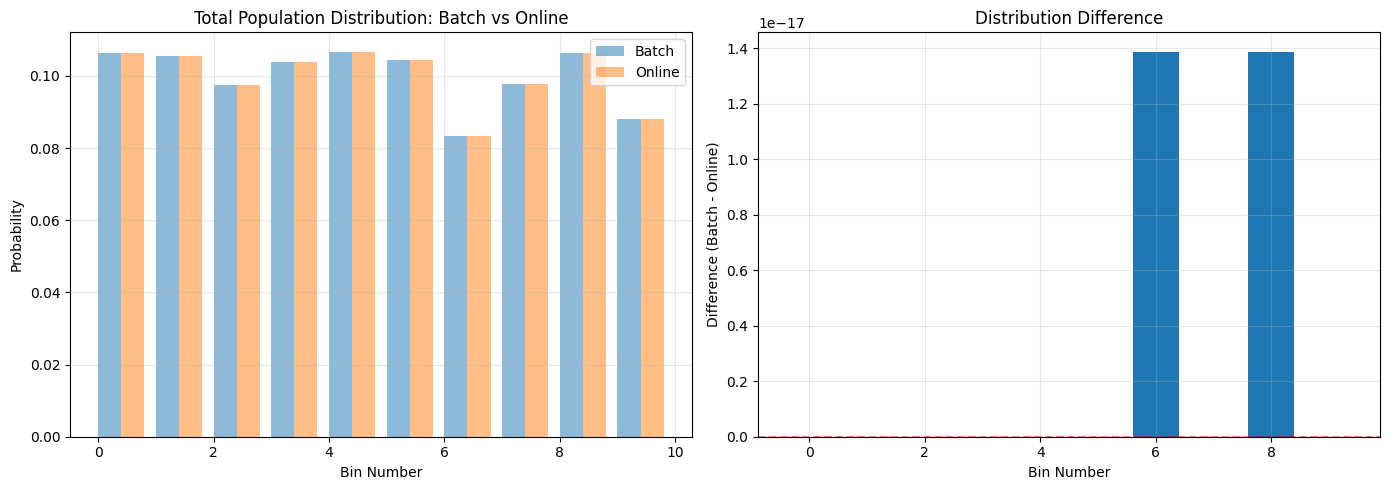


Maximum absolute difference in distributions: 1.39e-17


In [13]:
import matplotlib.pyplot as plt

# Get probability distributions from online accumulator
online_total_pop_dist = online_metrics['intermediate_data']['prob_dist_for_total_population_tensor']
online_label_dists = online_metrics['intermediate_data']['prob_dist_by_label_tensor']

# Get probability distributions from batch computation (already computed in Section 3.2-3.5)
batch_total_pop_dist = batch_metrics['intermediate_data']['prob_dist_for_total_population_tensor']
batch_label_dists = batch_metrics['intermediate_data']['prob_dist_by_label_tensor']

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Total population distribution comparison
axes[0].bar(range(n_bins), batch_total_pop_dist.numpy(), alpha=0.5, label='Batch', width=0.4, align='edge')
axes[0].bar([x + 0.4 for x in range(n_bins)], online_total_pop_dist.numpy(), alpha=0.5, label='Online', width=0.4, align='edge')
axes[0].set_xlabel('Bin Number')
axes[0].set_ylabel('Probability')
axes[0].set_title('Total Population Distribution: Batch vs Online')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: Difference between batch and online
diff = (batch_total_pop_dist - online_total_pop_dist).numpy()
axes[1].bar(range(n_bins), diff)
axes[1].set_xlabel('Bin Number')
axes[1].set_ylabel('Difference (Batch - Online)')
axes[1].set_title('Distribution Difference')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMaximum absolute difference in distributions: {abs(diff).max():.2e}")
